In [1]:
import glob
import numpy as np
import cv2
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import os
import tensorflow as tf
from matplotlib import pyplot as pl
from tensorflow.keras.layers import BatchNormalization


2024-05-23 07:38:07.115274: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-23 07:38:07.115397: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-23 07:38:07.280464: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Capture training image and masks info as a list
train_images = []
train_masks = []
for directory_path in glob.glob("/kaggle/input/chitwan-256/chitwan_256/images"):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = img.astype("float32")/65535.0  # Scaling to [0, 1]
        #img = img/65535  # Scaling to [0, 1]
        train_images.append(img)

train_images = np.array(train_images)
print(len(train_images))

# Capture mask/label info as a list
for directory_path in glob.glob("/kaggle/input/chitwan-256/chitwan_256/labels"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.tif")):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        # Normalize masks if necessary
        mask = mask.astype("float32")  # Scaling to [0, 1]
        train_masks.append(mask)

train_masks = np.array(train_masks)
print(len(train_masks))

2611
2611


In [24]:
# Shuffle indices
indices = np.arange(len(train_images))
np.random.shuffle(indices)

# Use shuffled indices to shuffle images and masks
shuffled_images = train_images[indices]
shuffled_masks = train_masks[indices]

# Calculate the number of samples for validation data
val_samples = int(0.2 * len(train_images))  # Assuming 20% of the data is for validation

# Split shuffled data into training and validation sets
x_train, x_val = shuffled_images[val_samples:], shuffled_images[:val_samples]
y_train, y_val = shuffled_masks[val_samples:], shuffled_masks[:val_samples]


In [25]:
print(f"Number of images loaded: {len(train_images)}")
print(f"Number of masks loaded: {len(train_masks)}")

# Check if any data has been loaded
if len(train_images) == 0 or len(train_masks) == 0:
    print("No data loaded. Please check your file paths.")
else:
    # Split data into training and validation sets
    #x_train, x_val, y_train, y_val = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)

    print(f"Number of training samples: {len(x_train)}")
    print(f"Number of validation samples: {len(x_val)}")

Number of images loaded: 2611
Number of masks loaded: 2611
Number of training samples: 2089
Number of validation samples: 522


In [27]:
lr=0.000001

In [29]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

inputs = Input(shape=(256, 256, 3))

# Encoder
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer='l2')(inputs)
x_temp = Dropout(0.3)(x_temp)
x_skip1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer='l2')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip1)
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer='l2')(x_temp)
x_temp = Dropout(0.3)(x_temp)
x_skip2 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer='l2')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip2)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer='l2')(x_temp)
x_temp = Dropout(0.3)(x_temp)
x_skip3 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer='l2')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip3)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer='l2')(x_temp)
x_temp = Dropout(0.4)(x_temp)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer='l2')(x_temp)

# Decoder
x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same', kernel_regularizer='l2')(x_temp)
x_temp = Dropout(0.4)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same', kernel_regularizer='l2')(x_temp)
x_temp = Concatenate()([x_temp, x_skip3])
x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same', kernel_regularizer='l2')(x_temp)
x_temp = Dropout(0.4)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same', kernel_regularizer='l2')(x_temp)
x_temp = Concatenate()([x_temp, x_skip2])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same', kernel_regularizer='l2')(x_temp)
x_temp = Dropout(0.4)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu',  padding='same', kernel_regularizer='l2')(x_temp)
x_temp = Concatenate()([x_temp, x_skip1])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same', kernel_regularizer='l2')(x_temp)
x_temp = Dropout(0.4)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same', kernel_regularizer='l2')(x_temp)

# Use 1 by 1 Convolution to get desired output bands
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same', kernel_regularizer='l2')(x_temp)
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same', kernel_regularizer='l2')(x_temp)
outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x_temp)

model1 = Model(inputs=inputs, outputs=outputs)
model1.compile(optimizer = Adam(learning_rate=lr), loss = 'binary_crossentropy', metrics = ['accuracy', 'mse'])

# Model summary
model1.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 256, 256,  │        896 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 256, 256,  │          0 │ conv2d_44[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 256, 256,  │      9,248 │ dropout_20[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 128, 128,  │          0 │ conv2d_45[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 128, 128,  │      9,248 │ max_pooling2d_12… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 128, 128,  │          0 │ conv2d_46[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 128, 128,  │      9,248 │ dropout_21[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 64, 64,    │          0 │ conv2d_47[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_13… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 64, 64,    │          0 │ conv2d_48[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 64, 64,    │     36,928 │ dropout_22[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 32, 32,    │          0 │ conv2d_49[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 32, 32,    │     36,928 │ max_pooling2d_14… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 32, 32,    │          0 │ conv2d_50[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 32, 32,    │     36,928 │ dropout_23[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_32 │ (None, 32, 32,    │     36,928 │ conv2d_51[0][0] 

 Total params: 409,281 (1.56 MB)

 Trainable params: 409,281 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)




In [8]:
batch_size = 4
train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)

In [25]:
print(len(x_train))
steps_per_epoch=len(x_train) // batch_size
print((steps_per_epoch))

30031
938


In [30]:
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

In [ ]:
# Fit the model
history= model1.fit(
        train_generator,
        #steps_per_epoch=len(x_train) // batch_size,
        epochs=30,  # Change as needed
        validation_data=(x_val,y_val) # Assuming you have validation data
       # callbacks=earlyStopping
        )

Epoch 1/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 68s 180ms/step - accuracy: 0.0144 - loss: 9.0010 - mse: 4719.1128 - val_accuracy: 0.0000e+00 - val_loss: 8.9180 - val_mse: 4427.4805
Epoch 2/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 30s 111ms/step - accuracy: 0.0000e+00 - loss: 8.8858 - mse: 5065.6328 - val_accuracy: 0.0000e+00 - val_loss: 8.8078 - val_mse: 4427.4658
Epoch 3/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 30s 111ms/step - accuracy: 0.0000e+00 - loss: 8.7737 - mse: 4982.7383 - val_accuracy: 0.0000e+00 - val_loss: 8.6968 - val_mse: 4427.4492
Epoch 4/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 30s 111ms/step - accuracy: 0.0000e+00 - loss: 8.6638 - mse: 4766.7510 - val_accuracy: 0.0000e+00 - val_loss: 8.5841 - val_mse: 4427.4316
Epoch 5/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 30s 111ms/step - accuracy: 0.0000e+00 - loss: 8.5478 - mse: 4822.7207 - val_accuracy: 0.0000e+00 - val_loss: 8.4694 - val_mse: 4427.4121
Epoch 6/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 30s 112ms/step - accuracy: 0.0000e+00 - loss: 8.4142 - mse: 5221.2642 - val_acc

accuracy = model1.evaluate(x_val, y_val)
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
import matplotlib.pyplot as plt
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#model.save('test1')

In [21]:
# Train the model
history = model1.fit(x_train,y_train, validation_data=(x_val, y_val), 
                    epochs=25, batch_size=8,callbacks=earlyStopping)

Epoch 1/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 59s 155ms/step - accuracy: 0.0038 - loss: 8.7056 - mse: 5229.0142 - val_accuracy: 0.0000e+00 - val_loss: 7.5911 - val_mse: 5063.9604
Epoch 2/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - accuracy: 0.0000e+00 - loss: 5.9331 - mse: 4999.7471 - val_accuracy: 0.0000e+00 - val_loss: -97.3548 - val_mse: 5045.6260
Epoch 3/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 26s 99ms/step - accuracy: 0.0000e+00 - loss: -259.9702 - mse: 4726.5391 - val_accuracy: 0.0000e+00 - val_loss: -291.1563 - val_mse: 5045.1123
Epoch 4/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 26s 98ms/step - accuracy: 0.0000e+00 - loss: -264.7592 - mse: 4576.6396 - val_accuracy: 0.0000e+00 - val_loss: -294.3225 - val_mse: 5045.1079
Epoch 5/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 26s 98ms/step - accuracy: 0.0000e+00 - loss: -304.1364 - mse: 5186.7554 - val_accuracy: 0.0000e+00 - val_loss: -294.8929 - val_mse: 5045.1079
Epoch 5: early stopping


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.0000e+00 - loss: -304.8014 - mse: 5137.1284 


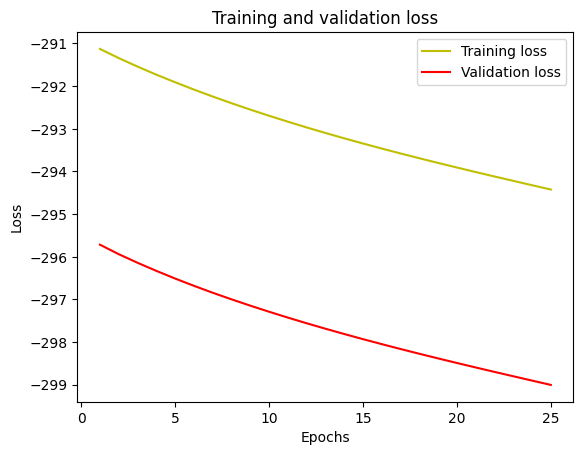

In [13]:
accuracy = model1.evaluate(x_val, y_val)
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
import matplotlib.pyplot as plt
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#model.save('test1')

In [ ]:
# unet model from pardhe bhai

def UNet(trained_weights = None, input_size = (256,256,3), drop_rate = 0.25, lr=0.0001):

    # Code modified from https://github.com/zhixuhao/unet
    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size)

    # Hidden layers
    ## Contraction phase
    conv1 = convBlock(inputs, 64, 3)
    conv1 = convBlock(conv1, 64, 3)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = convBlock(pool1, 128, 3)
    conv2 = convBlock(conv2, 128, 3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    #drop2 = Dropout(drop_rate)(pool2)

    conv3 = convBlock(pool2, 256, 3)
    conv3 = convBlock(conv3, 256, 3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    #drop3 = Dropout(drop_rate)(pool3)

    conv4 = convBlock(pool3, 512, 3)
    conv4 = convBlock(conv4, 512, 3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    #drop4 = Dropout(drop_rate)(pool4)

    conv5 = convBlock(pool4, 1024, 3)
    conv5 = convBlock(conv5, 1024, 3)

    ## Expansion phase
    up6 = (Conv2DTranspose(512, kernel_size=2, strides=2)(conv5))
    #up6 = (UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv4,up6])
    conv6 = convBlock(merge6, 512, 3)
    conv6 = convBlock(conv6, 512, 3)
    #conv6 = Dropout(drop_rate)(conv6)

    up7 = (Conv2DTranspose(256, kernel_size=2, strides=2)(conv6))
    #up7 = (UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7])
    conv7 = convBlock(merge7, 256, 3)
    conv7 = convBlock(conv7, 256, 3)
    #conv7 = Dropout(drop_rate)(conv7)

    up8 = (Conv2DTranspose(128, kernel_size=2, strides=2)(conv7))
    #up8 = (UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8])
    conv8 = convBlock(merge8, 128, 3)
    conv8 = convBlock(conv8, 128, 3)
    #conv8 = Dropout(drop_rate)(conv8)

    up9 = (Conv2DTranspose(64, kernel_size=2, strides=2)(conv8))
    #up9 = (UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9])
    conv9 = convBlock(merge9, 64, 3)
    conv9 = convBlock(conv9, 64, 3)
    conv10 = convBlock(conv9, 1, 1, act='sigmoid')


    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(learning_rate = lr), loss = 'binary_crossentropy', metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

In [40]:
# Train the model
history = model1.fit(x_train,y_train, validation_data=(x_val, y_val), 
                    epochs=25, batch_size=8)

Epoch 1/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 30s 161ms/step - loss: 0.0472 - mse: 0.0037 - val_loss: 0.0154 - val_mse: 2.7594e-04
Epoch 2/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 29s 155ms/step - loss: 0.0147 - mse: 6.6357e-04 - val_loss: 0.0049 - val_mse: 2.4423e-05
Epoch 3/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 29s 153ms/step - loss: 0.0062 - mse: 1.7374e-04 - val_loss: 0.0026 - val_mse: 6.8718e-06
Epoch 4/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 29s 154ms/step - loss: 0.0034 - mse: 5.6308e-05 - val_loss: 0.0019 - val_mse: 9.0172e-06
Epoch 5/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 29s 154ms/step - loss: 0.0021 - mse: 2.0344e-05 - val_loss: 0.0011 - val_mse: 1.3135e-06
Epoch 6/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 29s 154ms/step - loss: 0.0014 - mse: 8.1122e-06 - val_loss: 8.2448e-04 - val_mse: 6.8621e-07
Epoch 7/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 29s 154ms/step - loss: 0.0010 - mse: 4.1196e-06 - val_loss: 6.0798e-04 - val_mse: 3.8190e-07
Epoch 8/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 29s 154ms/step - loss: 7.6418e-04 - mse: 2.1845e-06 -

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.0000e+00 - loss: -300.6771 - mse: 5137.1294


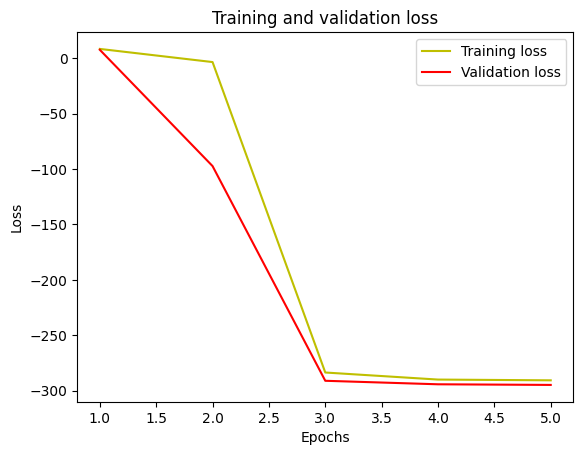

In [22]:
accuracy = model1.evaluate(x_val, y_val)
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
import matplotlib.pyplot as plt
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#model.save('test1')

235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Predicted mask saved: 000000000000_predicted.tif
Predicted mask saved: 000000000001_predicted.tif
Predicted mask saved: 000000000002_predicted.tif
Predicted mask saved: 000000000003_predicted.tif
Predicted mask saved: 000000000004_predicted.tif
Predicted mask saved: 000000000005_predicted.tif
Predicted mask saved: 000000000006_predicted.tif
Predicted mask saved: 000000000007_predicted.tif
Predicted mask saved: 000000000008_predicted.tif
Predicted mask saved: 000000000009_predicted.tif
Predicted mask saved: 000000000010_predicted.tif
Predicted mask saved: 000000000011_predicted.tif
Predicted mask saved: 000000000012_predicted.tif
Predicted mask saved: 000000000013_predicted.tif
Predicted mask saved: 000000000014_predicted.tif
Predicted mask saved: 000000000015_predicted.tif
Predicted mask saved: 000000000016_predicted.tif
Predicted mask saved: 000000000017_predicted.tif
Predicted mask saved: 000000000018_predicted.tif
Predicted mask saved: 000000

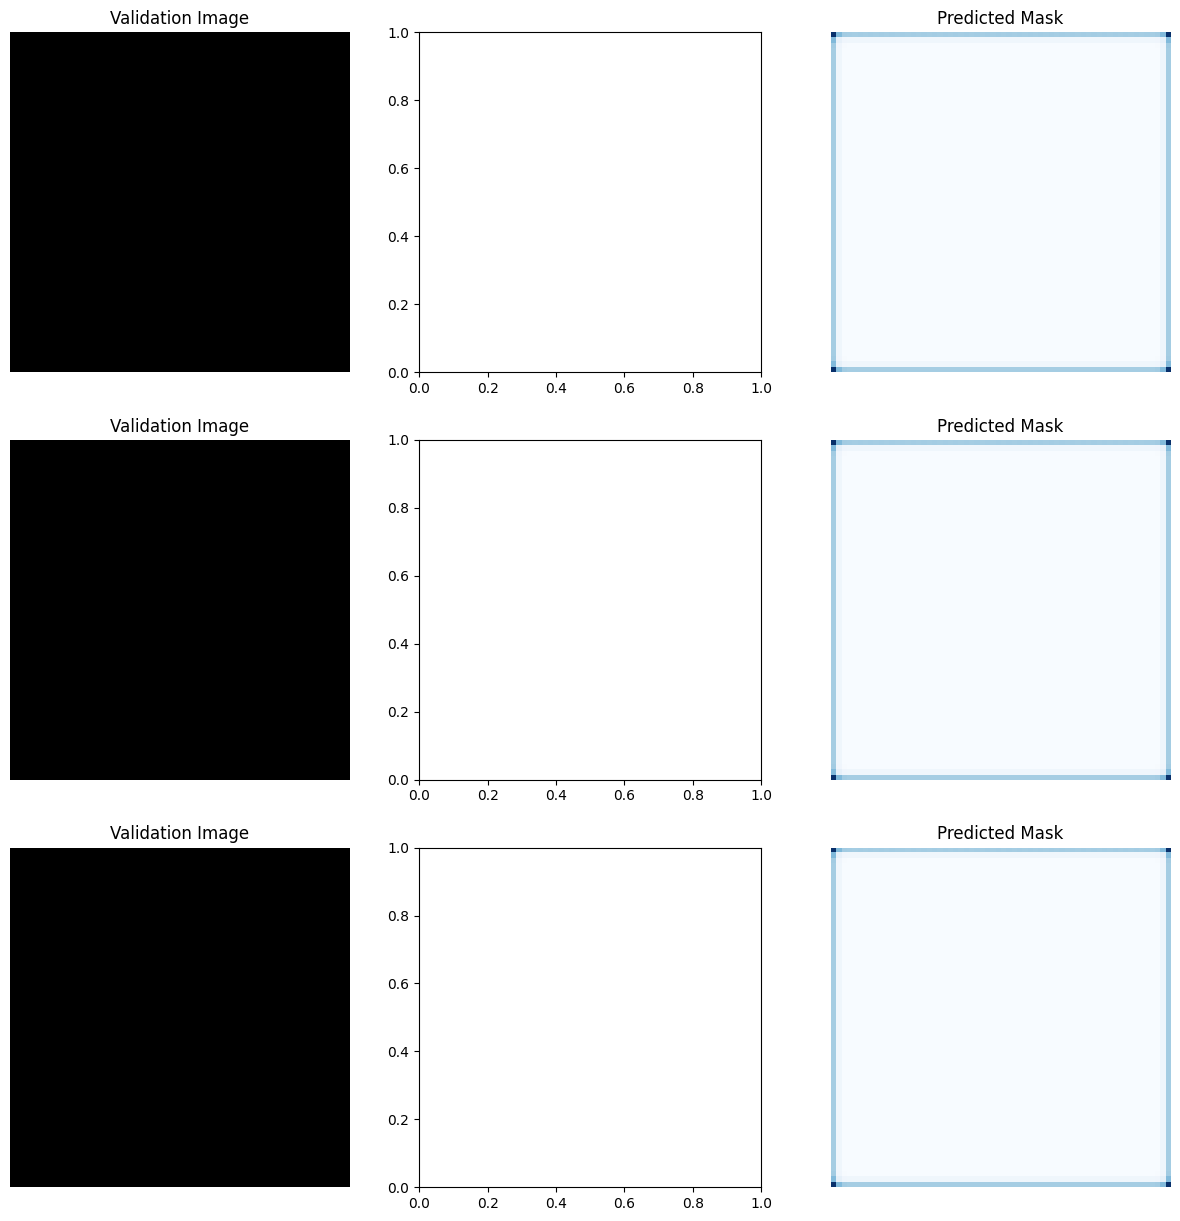

In [20]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Create a directory to save the predicted masks
output_dir = "/kaggle/working/predicted_masks6/"
os.makedirs(output_dir, exist_ok=True)

# Predict masks for validation data
predicted_masks = model1.predict(x_val)

# Ensure predictions are in the correct range [0, 1]
predicted_masks = np.clip(predicted_masks, 0, 1)

# Get the original filenames for validation images
val_image_paths = sorted(glob.glob("/kaggle/input/chit64/chit64/images/*.tif"))[:len(x_val)]

# Save predicted masks with corresponding names
for i, val_image_path in enumerate(val_image_paths):
    # Get the base name of the original image file
    base_name = os.path.basename(val_image_path)
    mask_name = base_name.replace(".tif", "_predicted.tif")
    
    # Save the predicted mask
    predicted_mask = (predicted_masks[i] * 65535).astype(np.uint8)
    cv2.imwrite(os.path.join(output_dir, mask_name), predicted_mask)
    
    print(f"Predicted mask saved: {mask_name}")

# Visualize some of the predictions
num_examples = 3
fig, axes = plt.subplots(num_examples, 3, figsize=(15, 15))

for i in range(num_examples):
    # Original image
    axes[i, 0].imshow(x_val[i])
    axes[i, 0].set_title("Validation Image")
    axes[i, 0].axis('off')
    
    # Predicted mask
    axes[i, 2].imshow(predicted_masks[i], cmap='Blues')
    axes[i, 2].set_title("Predicted Mask")
    axes[i, 2].axis('off')

plt.show()


In [22]:
from zipfile import ZipFile 
 

In [23]:
# Create a zip file of the predicted masks
zip_filename = "/kaggle/working/predicted_mask6"
with ZipFile(zip_filename, 'w') as zipf:
    for root, dirs, files in os.walk(output_dir):
        for file in files:
            zipf.write(os.path.join(root, file), arcname=file)

print(f"Zip file created: {zip_filename}")

Zip file created: /kaggle/working/predicted_mask6
